In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.01):
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviatiaon = np.std(negative_returns, ddof=1)
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sortino_ratio = np.mean(excess_daily_returns) / downside_deviatiaon
    return sortino_ratio * np.sqrt(252)  # annualised

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns, ddof=1)
    return sharpe_ratio * np.sqrt(252)  # annualised

def calculate_maximum_drawdown(cumulative_returns):
    cumulative_returns = np.array(cumulative_returns) + 1
    if len(cumulative_returns) > 0:
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdowns = (running_max - cumulative_returns) / running_max
        max_drawdown = np.max(drawdowns)
        return max_drawdown
    else:
        return 0

def calculate_calmar_ratio(annual_return, max_drawdown):
    # if max_drawdown is negative, make it positive for the ratio
    return annual_return / abs(max_drawdown)

In [3]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# June (Test)
#data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()

In [11]:
def run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation
    buy_signals = 0
    sell_signals = 0

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.005
    exchange_fee_per_share = 0.003
    shares_per_transaction = 500

    look_ahead_window = 5 
    look_back_window = 20
  
    for i in range(look_back_window, len(data) - look_ahead_window):
        # Mid_price
        current_mid_price = data.iloc[i]['Mid-Price']
        future_prices = data.iloc[i+1:i+look_ahead_window+1]['Mid-Price']
        future_avg_price = future_prices.mean()
        current_RSI = data.iloc[i]['RSI']
        # Bid_ask_spread      
        bid_ask_spread_threshold = data.iloc[i-look_back_window:i]['Bid_Ask_Spread'].quantile(quantile_optimised)
        future_bid_ask = data.iloc[i+1:i+look_ahead_window+1]['Bid_Ask_Spread']
        future_bid_ask_avg = future_bid_ask.mean()
        is_liquid = future_bid_ask_avg <= bid_ask_spread_threshold

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0 and current_RSI <= buy_threshold:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
            buy_signals += 1

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0 and current_RSI >= sell_threshold:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0
            sell_signals += 1

        # Hold condition
        else: 
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Performance Metrics
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna() # daily returns from portfolio values
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data)) - 1
    else:
        # cases where annual return cannot be computed
        annual_return = None
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return initial_cash, final_valuation, final_valuation - initial_cash, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# optimised parameters
future_buy_increase = 1.01
future_sell_decrease = 0.97
quantile_optimised = 0.85
buy_threshold = 40
sell_threshold = 60

# Run simulation
results = []
initial_cash, final_valuation, profit_loss, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns = run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised)

# Make trading signal 'Hold' as default
data['Trading Signal'] = 'Hold'
# update the DataFrame with transactions for training of RF
for transaction in transactions:
    signal_type, shares, price, cost, cash, day_index = transaction
    data.at[day_index, 'Trading Signal'] = signal_type

# Append results to a list
results.append((future_buy_increase, future_sell_decrease, quantile_optimised, profit_loss, len(transactions), buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease', 'Bid Ask Spread Threshold', 'Profit/Loss', 'Number of Transactions', 'Number of Buy Signals', 'Number of Sell Signals', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
results_df.to_csv('Jan-May Trading Simulation Results + RSI.csv')

# Output data with signals
data.to_csv('Jan-May Data with Trading Signals + RSI.csv') 

results_df.head(50)


,Future Buy Increase,Future Sell Decrease,Bid Ask Spread Threshold,Profit/Loss,Number of Transactions,Number of Buy Signals,Number of Sell Signals,Sortino Ratio,Sharpe Ratio,Max Drawdown,Calmar Ratio
0,1.01,0.97,0.85,70088.325762,52492,530,194,0.436572,0.329671,0.588329,0.024757


In [12]:
daily_returns
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns

1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
           ...   
52487    7.008833
52488    7.008833
52489    7.008833
52490    7.008833
52491    7.008833
Length: 52491, dtype: float64

Plot Training Data Figure

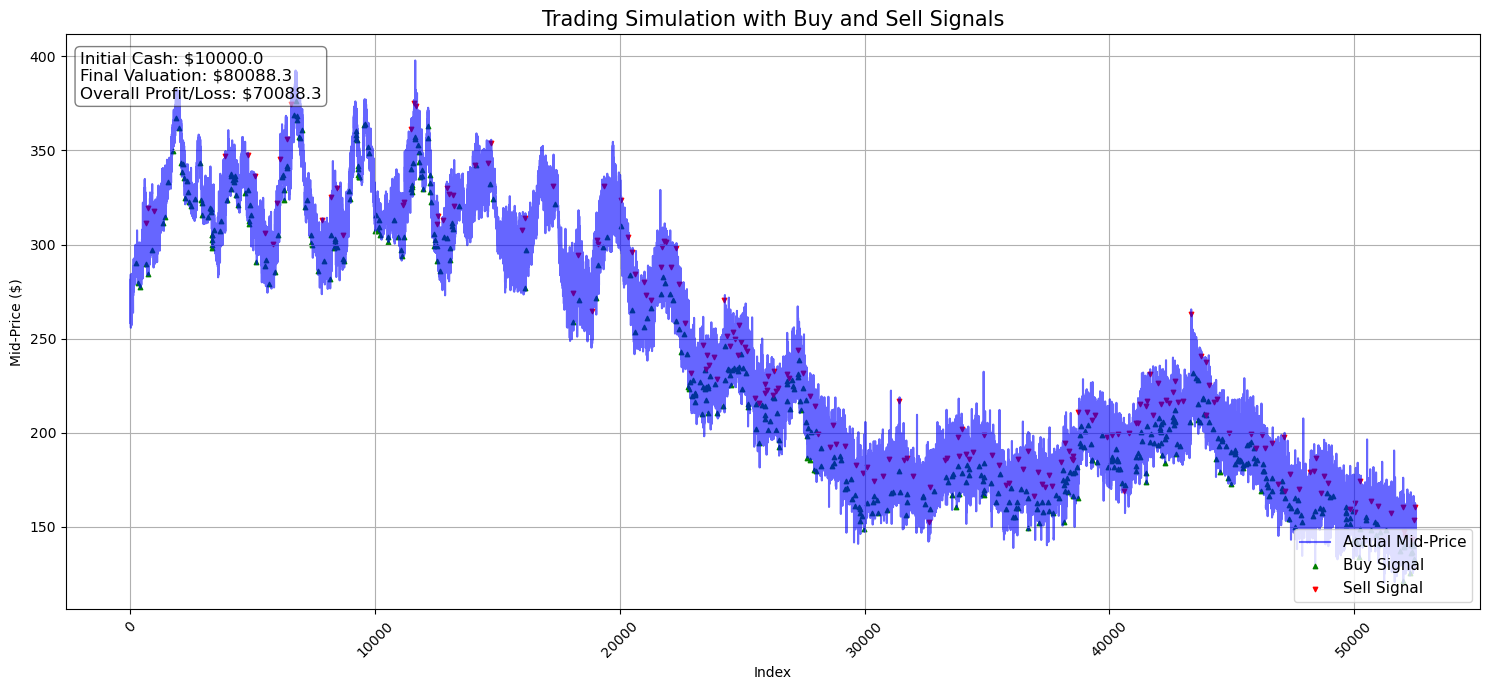

In [13]:
# Convert transactions to a DataFrame
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data.index, data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)


# Add buy and sell signals on index points
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals.index, buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals.index, sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# Add labels with model results
final_valuation = final_valuation  # final calculation from the simulation
initial_cash = initial_cash  # from outputs
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Index')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

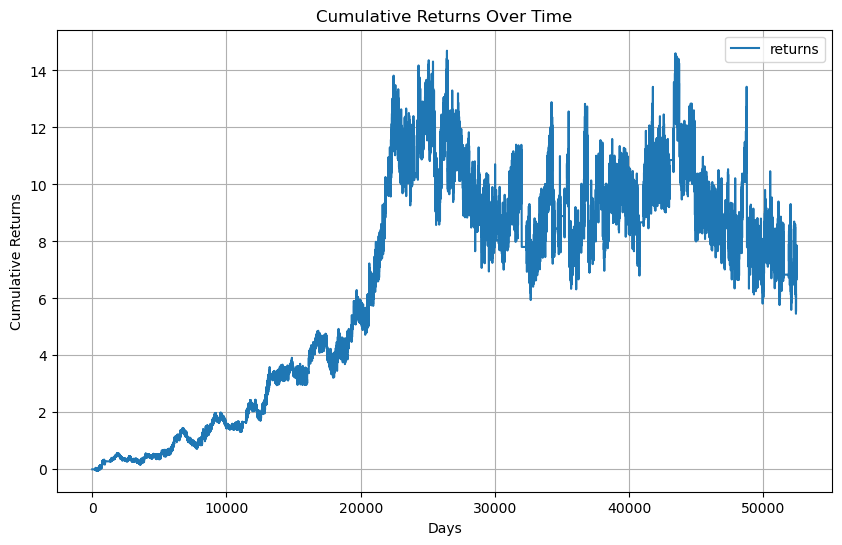

In [14]:

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='returns')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Days')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
